## Part 1

In [1]:
from scipy.special import beta
import numpy as np

a = 0
b = 10
c = 100

E = (a + 4*b + c)/6
var = (E - a) * (c - E) / 7
print(f"E[X] = {E}")
print(f"var[X] = {var}")

def p(x, a=0, b=10, c=100):
    x = np.array(x, dtype=np.float64)

    alpha = 1 + 4 * (b - a) / (c - a)
    beta_ = 1 + 4 * (c - b) / (c - a)

    pdf = np.zeros_like(x)
    mask = (x >= a) & (x <= c)

    num = (x[mask] - a) ** (alpha - 1) * (c - x[mask]) ** (beta_ - 1)
    denom = beta(alpha, beta_) * (c - a) ** (alpha + beta_ - 1)

    pdf[mask] = num / (denom + 1e-8)
    return pdf

E[X] = 23.333333333333332
var[X] = 255.55555555555557


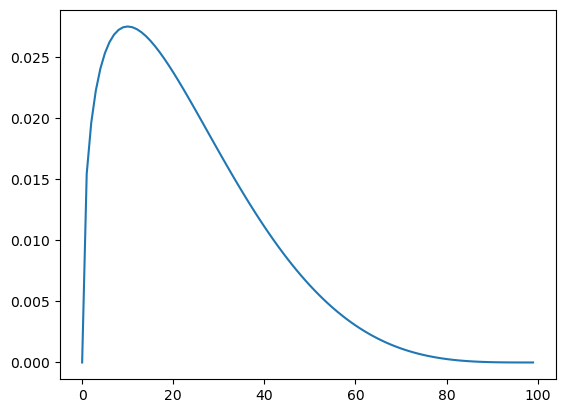

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x_vec = np.arange(a,c,1)
vals = [p(x) for x in x_vec]
plt.plot(x_vec, vals)
#plt.plot(x_vec, np.ones_like(x_vec) / len(x_vec))

### 1.1

In [20]:
def expected_value_integrand_p(x):
    return p(x) * x

def trapezoidal(fun, x0, xn, n):
    interval = (xn - x0) / n
    integral = 0
    
    x_prev = x0

    for x in np.arange(x0 + interval, xn + interval / 10, interval):
        integral += (x - x_prev)/2 * (fun(x) + fun(x_prev))

        x_prev = x

    return integral

for n in range(1,500):
    diff = np.abs(E - trapezoidal(expected_value_integrand_p, a, c, n)) 
    if diff < 5e-5:
        print(f"Difference between actual E[X] and approximated")
        print("---------------------------------------------------------")
        print(f"E[x] - E_hat[X] = {diff} using {n} samples")
        break

Difference between actual E[X] and approximated
---------------------------------------------------------
E[x] - E_hat[X] = 4.957722734388881e-05 using 271 samples


### 1.2 was done by hand

### 1.3

In [ ]:
np.random.seed(42)


for _ in range(10):
    n = 9413605

    estimates = []

    x = np.random.uniform(0,100, size=n)
    fx = 100 * expected_value_integrand_p(x)

    print(f"Average: {np.mean(fx) :.5f}")
    print(f"Std: {np.std(fx) / np.sqrt(n)}")

    # Actual diff
    diff = np.abs(np.mean(fx) - E)
    print(f"Diff: {diff}")

Average: 23.32883
Std: 0.006218402351641426
Diff: 0.004503095774506249
Average: 23.33704
Std: 0.0062189591921063166
Diff: 0.003706061934558136
Average: 23.33190
Std: 0.006217868607202644
Diff: 0.001429876031000532
Average: 23.34266
Std: 0.0062181012237719465
Diff: 0.009329383188394047
Average: 23.32511
Std: 0.006217777475922076
Diff: 0.008219199737659721
Average: 23.33438
Std: 0.006218744849493911
Diff: 0.001049479415573984
Average: 23.33460
Std: 0.006218773351427213
Diff: 0.0012709988174677278
Average: 23.34622
Std: 0.006219525760537308
Diff: 0.012887610715907272
Average: 23.33935
Std: 0.006218308108640831
Diff: 0.006012959370949034
Average: 23.33824
Std: 0.006218719693825996
Diff: 0.0049100018161070125


-0.031087913159705494


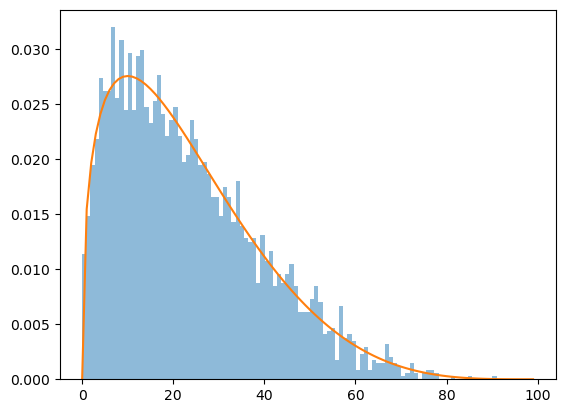

In [5]:
np.random.seed(42)
# Rejection sampling
M = 3
n = 11317

x = np.random.uniform(a,c, size=n)

u = np.random.uniform(0, M * 1 / (c -a), size=n)

# Accept 
accepted = u < p(x)
samples = x[accepted]

print(np.mean(samples) - E)

plt.hist(samples, bins=100, alpha=0.5, label='u samples', density=True)
plt.plot(x_vec, vals)
plt.show()

## Part 2

### 2.1

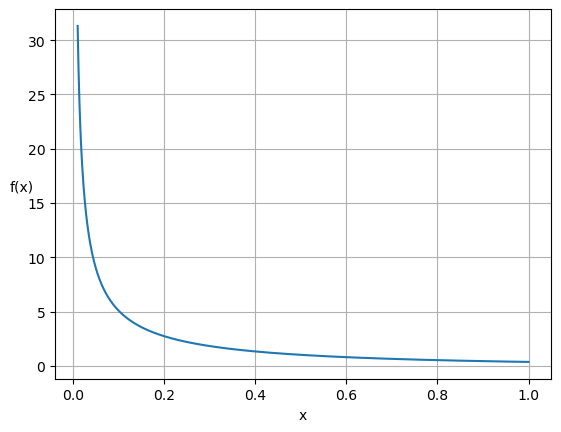

In [6]:
def integrand(x):
    return x**(-3/4) * np.exp(-x)

x = np.linspace(1e-2,1, 1000)
plt.plot(x, integrand(x))
plt.xlabel("x")
plt.ylabel("f(x)", rotation=0)
plt.grid(True)

### 2.2

In [17]:
np.random.seed(42)
n = 10**7

estimates = []


for _ in range(10):
    x = np.random.uniform(0,1, size=n)
    fx = integrand(x)

    estimates.append(np.mean(fx))

print(f"{np.mean(estimates)} +/- {np.std(estimates) }")


3.3639559852290715 +/- 0.08895371562338893


### 2.3

In [19]:
def q(x, c = 1/4):
    return c * x**(-3/4)

def q_cdf(x):
    return x**(1/4)

def q_cdf_inv(x):
    return x**4

np.random.seed(42)
n = 10**7
estimates = []

for _ in range(10):
    u = np.random.uniform(0, 1, size=n)
    x = q_cdf_inv(u)  # samples from q(x)
    fx = integrand(x)
    qx = q(x)
    weights = fx / qx

    estimates.append(np.mean(weights))


print(f"{np.mean(estimates)} +/- {np.std(estimates)}")

3.379466236404859 +/- 0.00014274478809652816


### 2.4 - maybe make a graph of both with uncertainties

## 3

### 3.1

In [ ]:
def metropolis_hastings(posterior, initial, proposal_sample_fn, proposal_pdf_fn, iterations, data):
    samples = []
    current = np.array(initial)
    current_post = posterior(current[0], current[1], data)
    
    for _ in range(iterations):
        proposal = proposal_sample_fn(current)
        prop_post = posterior(proposal[0], proposal[1], data)

        q_forward = proposal_pdf_fn(proposal, current) 
        q_backward = proposal_pdf_fn(current, proposal) 

        ratio = min(1, (prop_post * q_backward) / (current_post * q_forward))

        if ratio > np.random.rand():
            current = proposal
            current_post = prop_post

        samples.append(current.copy())

    return np.array(samples)

In [10]:
def posterior(alpha, eta, data):
    if eta <= 0 or alpha <= 0:
        return 0

    likelihood = alpha * eta * data**(alpha - 1) * np.exp(-eta * data**alpha)
    likelihood = np.prod(likelihood)
    prior = np.exp((-alpha - 2 * eta)) * eta

    return likelihood * prior

In [11]:
from scipy.stats import multivariate_normal

def normal_proposal_fn(cov):
    def proposal(current):
        return np.random.multivariate_normal(current, cov)
    return proposal

def normal_proposal_pdf(cov):
    def pdf(x, mean):
        mvn = multivariate_normal(mean=mean, cov=cov)
        return mvn.pdf(x)
    return pdf

In [12]:
def proposal_distr():
    def proposal(current):
        alpha_curr, eta_curr = current
        alpha_new = np.random.exponential(scale=alpha_curr)
        eta_new = np.random.exponential(scale=eta_curr)
        return np.array([alpha_new, eta_new])
    return proposal

def proposal_distr_pdf():
    def pdf(x, mean):
        alpha_x, eta_x = x
        alpha_mean, eta_mean = mean

        if alpha_x <= 0 or eta_x <= 0:
            return 0.0

        alpha_pdf = (1 / alpha_mean) * np.exp(-alpha_x / alpha_mean)
        eta_pdf = (1 / eta_mean) * np.exp(-eta_x / eta_mean)

        return alpha_pdf * eta_pdf
    return pdf

In [27]:
import numpy as np

def autocorr(x, lag):
    n = len(x)
    if lag >= n:
        return np.nan
    x_mean = np.mean(x)
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]

def compute_ess(x, max_lag=None):
    n = len(x)
    if max_lag is None:
        max_lag = min(n // 2, 1000)

    rho_sum = 0
    for lag in range(1, max_lag):
        rho = autocorr(x, lag)
        if np.isnan(rho) or rho < 0:
            break
        rho_sum += rho

    return n / (1 + 2 * rho_sum)

def mcse_squared(x):
    s2 = np.var(x, ddof=1)
    ess = compute_ess(x)
    return s2 / ess


In [35]:
def print_mean_and_var(data, initial, proposal, proposal_den, iterations=1000, burn_in=0, cov=None):
    if cov is not None:
        proposal_fn = proposal(cov)
        proposal_pdf_fn = proposal_den(cov) 
    else:
        proposal_fn = proposal()
        proposal_pdf_fn = proposal_den()    

    # Run MH
    samples = metropolis_hastings(posterior, initial, proposal_fn, proposal_pdf_fn, iterations, data)

    # Discard burn-in
    samples = samples[burn_in:]

    # Extract α and η
    alpha_samples = samples[:, 0]
    eta_samples = samples[:, 1]

    # Print results
    print(f"Mean of α: {np.mean(alpha_samples):.4f}")
    print(f"Mean of η: {np.mean(eta_samples):.4f}")
    print(f"Variance of α: {mcse_squared(alpha_samples):.4f}")
    print(f"Variance of η: {mcse_squared(eta_samples):.4f}")

    return samples


In [ ]:
data = np.array([0.3, 0.5, 0.75, 0.4])
initial = [1.0, 1.0]

covariances = [
    np.array([[0.01, 0], [0, 0.01]]),
    np.array([[0.05, 0], [0, 0.05]]),
    np.array([[0.1, 0], [0, 0.1]]),
    np.array([[1.0, 0], [0, 1.0]]),
    np.array([[0.1, 0.05], [0.05, 0.1]]),
    np.array([[1, 0.0], [0.0, 1]])
]

samples_all = []

for cov in covariances:
    print("------------------")
    print("Covariance:\n", cov)
    
    samples = print_mean_and_var(data,  initial, normal_proposal_fn, proposal_den=normal_proposal_pdf, cov=cov)

    samples_all.append(samples)
    

print("------------------")
print("proposal distribution ")
samples = print_mean_and_var(data, initial, proposal_distr, proposal_distr_pdf)
samples_all.append(samples)


In [30]:
def trace_plot(alpha_samples, eta_samples):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(alpha_samples, label='α')
    plt.title("Trace of α")
    plt.subplot(1, 2, 2)
    plt.plot(eta_samples, label='η', color='orange')
    plt.title("Trace of η")
    plt.tight_layout()
    plt.show()


Chain 1 - Normal Proposal
Mean of α: 1.7226
Mean of η: 2.4892
Variance of α: 0.0088
Variance of η: 0.0689

Chain 1 - Exponential Proposal
Mean of α: 1.7539
Mean of η: 1.9149
Variance of α: 0.0049
Variance of η: 0.0074

Chain 2 - Normal Proposal
Mean of α: 1.5120
Mean of η: 1.2498
Variance of α: 0.0520
Variance of η: 0.0069

Chain 2 - Exponential Proposal
Mean of α: 1.9320
Mean of η: 1.9352
Variance of α: 0.0048
Variance of η: 0.0080

Chain 3 - Normal Proposal
Mean of α: 1.6295
Mean of η: 2.0501
Variance of α: 0.0085
Variance of η: 0.1256

Chain 3 - Exponential Proposal
Mean of α: 1.8548
Mean of η: 1.8844
Variance of α: 0.0048
Variance of η: 0.0099

Chain 4 - Normal Proposal
Mean of α: 2.1003
Mean of η: 3.2293
Variance of α: 0.0358
Variance of η: 0.9666

Chain 4 - Exponential Proposal
Mean of α: 1.6540
Mean of η: 1.7144
Variance of α: 0.0121
Variance of η: 0.0057

Chain 5 - Normal Proposal
Mean of α: 1.8612
Mean of η: 1.5625
Variance of α: 0.0244
Variance of η: 0.0447

Chain 5 - Expone

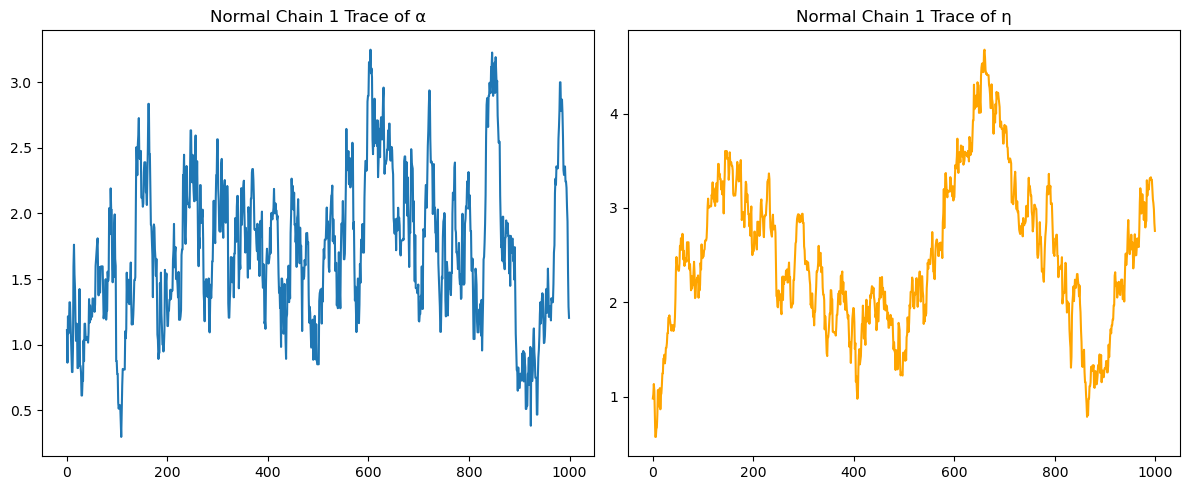

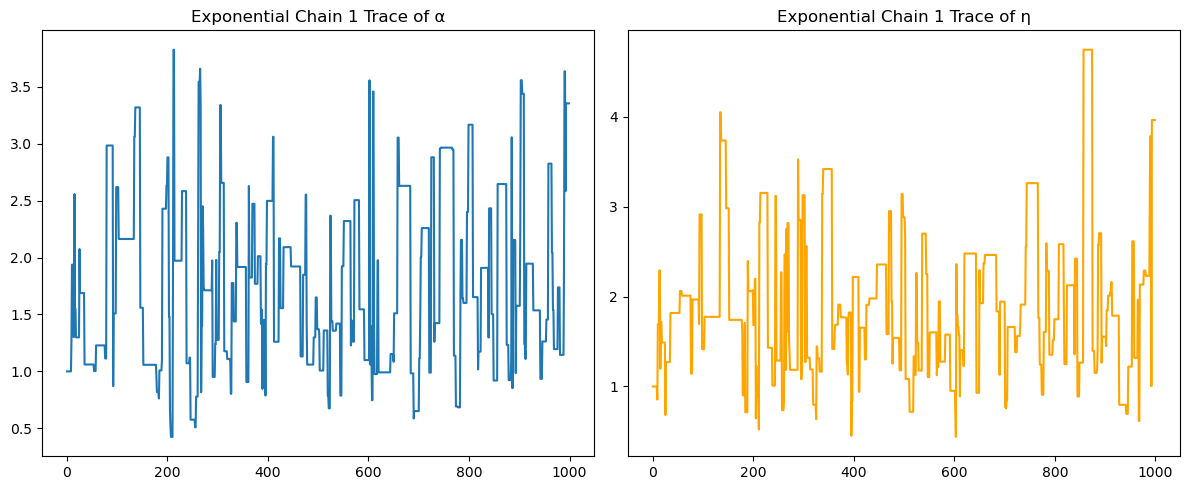

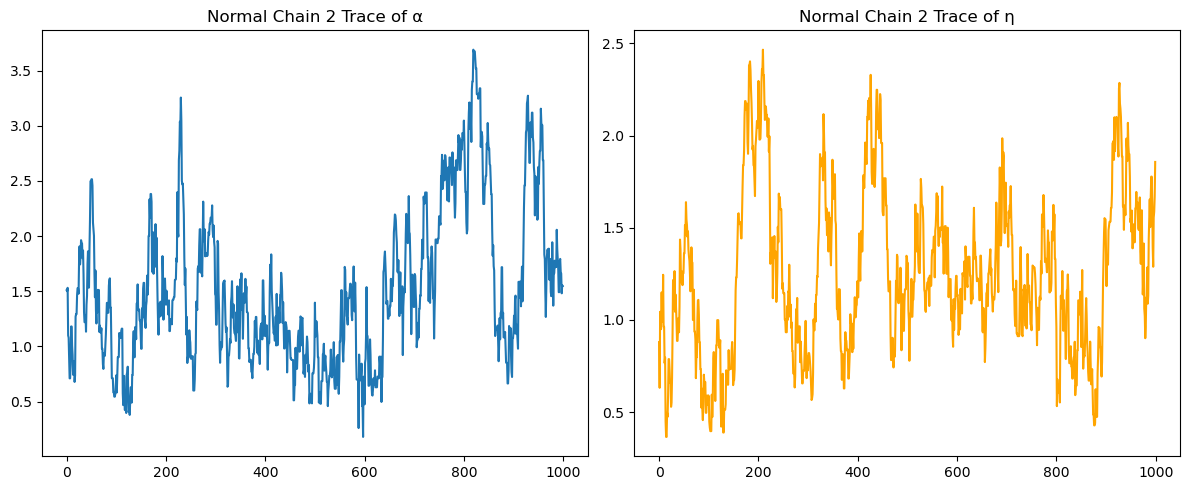

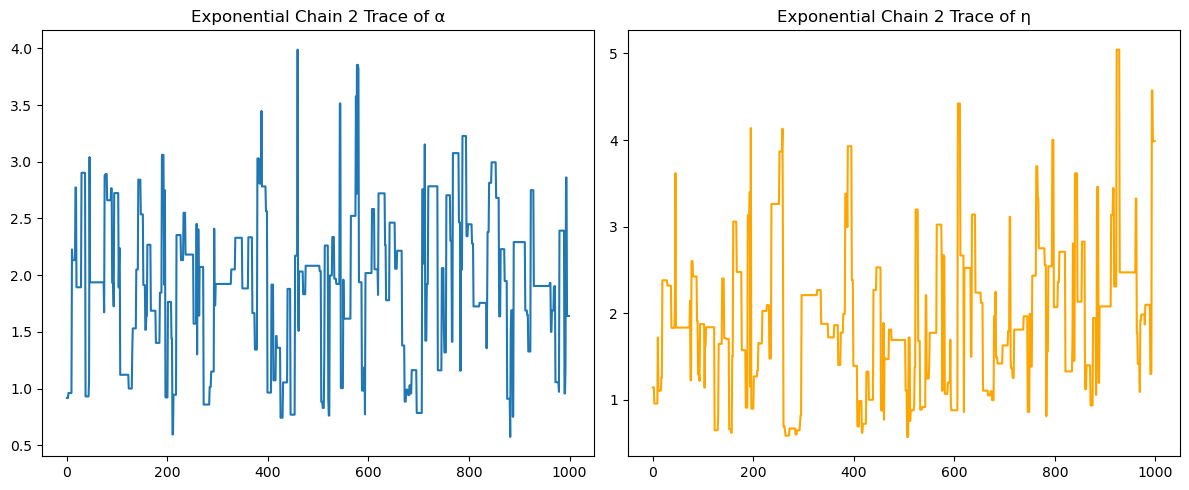

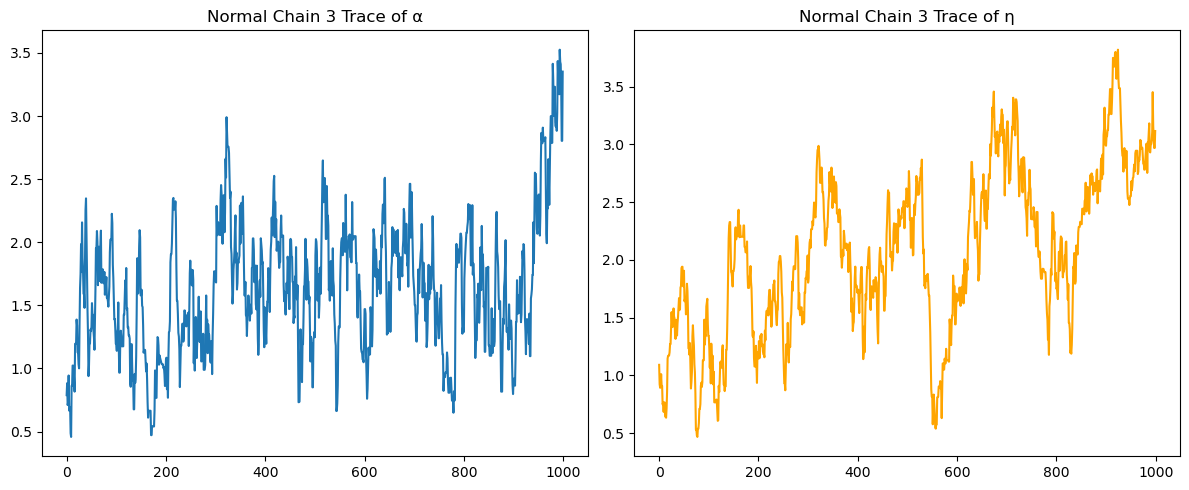

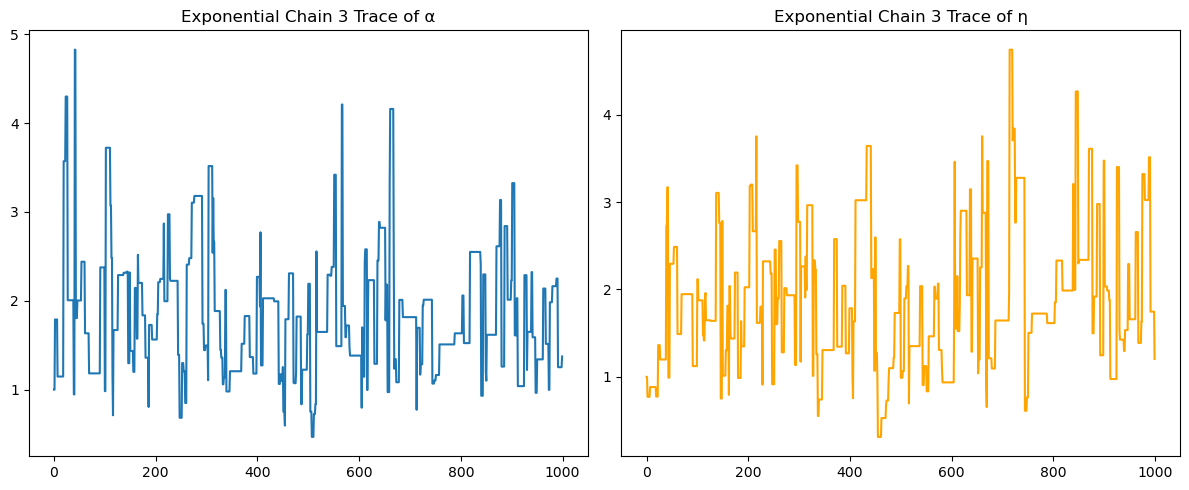

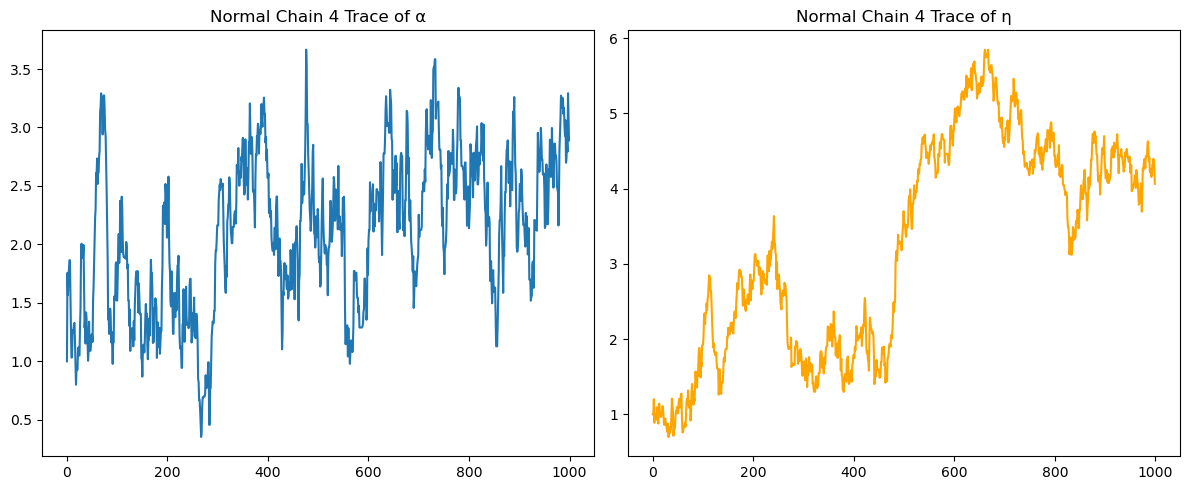

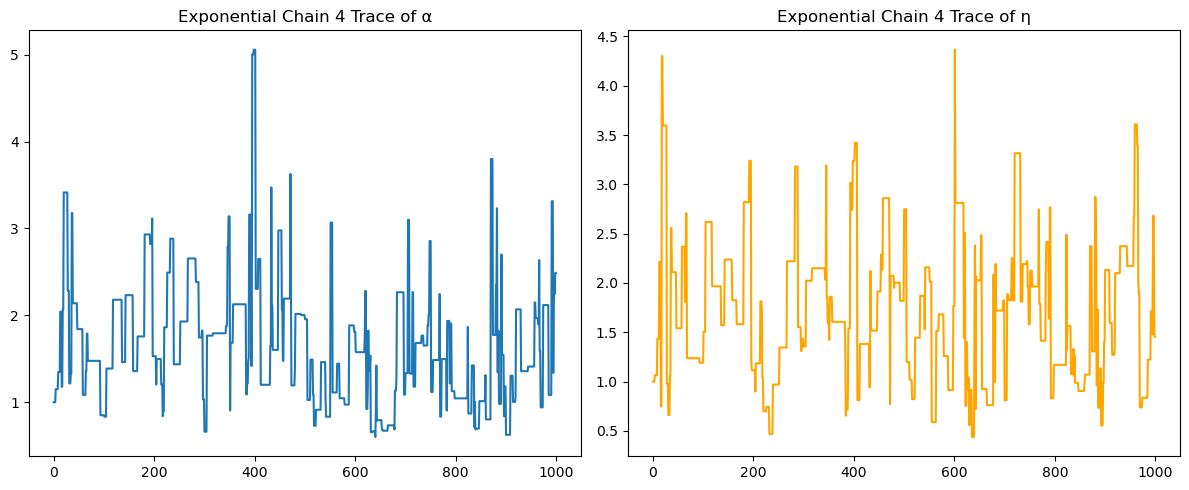

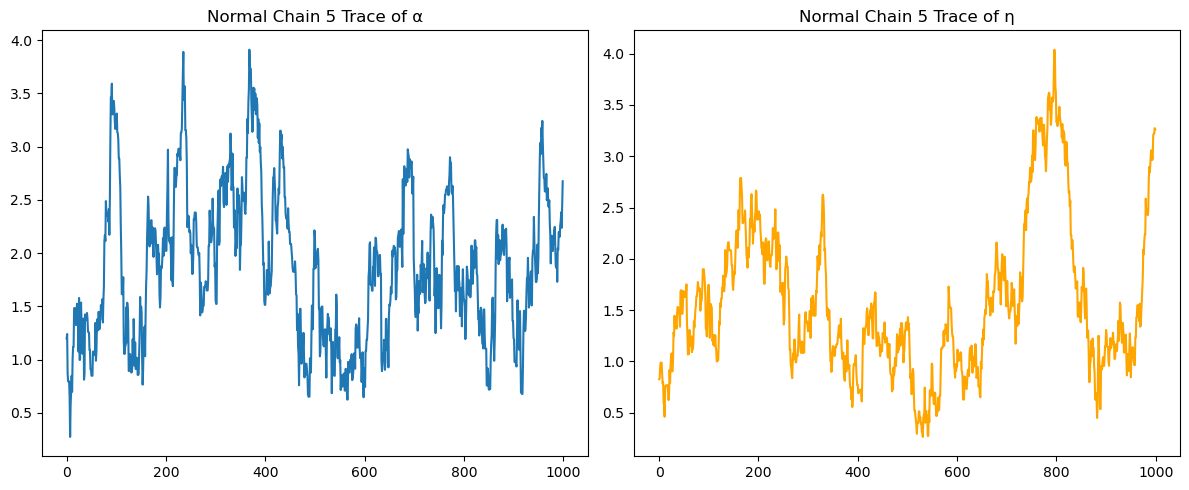

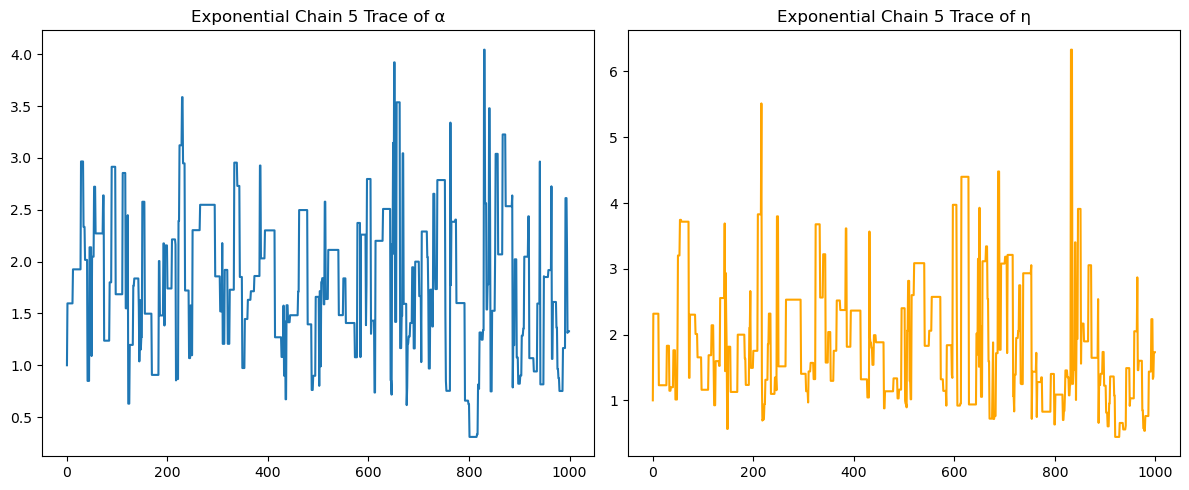

In [36]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n_chains = 5
n_samples = 1000

data = np.array([0.3, 0.5, 0.75, 0.4])
initial = [1.0, 1.0]

# Adjust this based on your desired covariance matrix
cov = np.array([[0.05, 0], [0, 0.02]])

normal_chains = []
exp_chains = []

# --- Collect samples for both proposal types ---
for i in range(n_chains):
    print(f"\nChain {i+1} - Normal Proposal")
    samples_normal = print_mean_and_var(data, initial, normal_proposal_fn, proposal_den=normal_proposal_pdf, cov=cov)
    normal_chains.append(samples_normal)

    print(f"\nChain {i+1} - Exponential Proposal")
    samples_exp = print_mean_and_var(data, initial, proposal_distr, proposal_distr_pdf)
    exp_chains.append(samples_exp)

# --- Plot traces ---
def trace_plot(alpha_samples, eta_samples, title_prefix=""):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(alpha_samples)
    plt.title(f"{title_prefix} Trace of α")
    plt.subplot(1, 2, 2)
    plt.plot(eta_samples, color='orange')
    plt.title(f"{title_prefix} Trace of η")
    plt.tight_layout()
    plt.show()

for i in range(n_chains):
    trace_plot(normal_chains[i][:, 0], normal_chains[i][:, 1], title_prefix=f"Normal Chain {i+1}")
    trace_plot(exp_chains[i][:, 0], exp_chains[i][:, 1], title_prefix=f"Exponential Chain {i+1}")
